In [5]:
## Dependencies
import pymongo
import pandas as pd
import geopandas as gpd

In [6]:
#MongoDB Connection

# The default port used by MongoDB is 27017
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

#Create "disastersmx" database
db = client.disastersmx

In [7]:
#Load data and transform

## SHAPE "PRECIPITACIONES"
dat_precip = gpd.read_file('../raw/atlas_de_riesgo_precipitacion/atlas_de_riesgo_precipitacion.shp')
dat_precip = dat_precip.loc[:,['id', 'alcaldi', 'intnsdd', 'geometry']]
dat_precip['id'] = pd.to_numeric(dat_precip['id'])
dat_precip = dat_precip.rename(columns={'intnsdd': 'riesgo_precipitacion', 'alcaldi': 'alcaldia'})

#csv riesgo sismico
dat_sismic = gpd.read_file('../raw/atlas-de-riesgo-sismico.csv')
dat_sismic = dat_sismic.loc[:,['id', 'intensidad']]
dat_sismic['id'] = pd.to_numeric(dat_sismic['id'])
dat_sismic = dat_sismic.rename(columns={'intensidad': 'riesgo_sismico'})

#csv riesgo granizo
dat_granizo = gpd.read_file('../raw/atlas-de-riesgo-granizo.csv')
dat_granizo = dat_granizo.loc[:,['id', 'intensidad']]
dat_granizo['id'] = pd.to_numeric(dat_granizo['id'])
dat_granizo = dat_granizo.rename(columns={'intensidad': 'riesgo_granizo'})

#csv riesgo inundaciones
dat_inun = gpd.read_file('../raw/atlas-de-riesgo-inundaciones.csv')
dat_inun = dat_inun.loc[:,['id', 'intensidad']]
dat_inun['id'] = pd.to_numeric(dat_inun['id'])
dat_inun = dat_inun.rename(columns={'intensidad': 'riesgo_inundacion'})

#csv riesgo derrumbe de laderas
dat_ladera = gpd.read_file('../raw/atlas-de-riesgo-susceptibilidad-por-laderas.csv')
dat_ladera = dat_ladera.loc[:,['id', 'intensidad']]
dat_ladera['id'] = pd.to_numeric(dat_ladera['id'])
dat_ladera = dat_ladera.rename(columns={'intensidad': 'riesgo_laderas'})

#csv riesgo tormenta electrica
dat_electr =  gpd.read_file('../raw/atlas-de-riesgo-tormentas-electricas.csv')
dat_electr = dat_electr.loc[:,['id', 'intensidad']]
dat_electr['id'] = pd.to_numeric(dat_electr['id'])
dat_electr = dat_electr.rename(columns={'intensidad': 'riesgo_tormentaElectrica'})

## UNIFICAR TABLAS
dat = pd.merge(dat_precip, dat_sismic, on= ['id'], how= 'left')
dat = dat.merge(dat_granizo, on= 'id', how= 'left')
dat = dat.merge(dat_inun, on= 'id', how= 'left')
dat = dat.merge(dat_ladera, on= 'id', how= 'left')
dat = dat.merge(dat_electr, on= 'id', how= 'left')

dat = dat.drop_duplicates()\
.reset_index()
dat = dat.loc[:,['id', 'alcaldia', 'riesgo_precipitacion', 'riesgo_sismico', 'riesgo_granizo',
                 'riesgo_inundacion', 'riesgo_laderas', 'riesgo_tormentaElectrica', 'geometry']]

dat.head()

id      alcaldia riesgo_precipitacion riesgo_sismico riesgo_granizo  \
0  817  lvaro Obregn                Medio          Medio       Muy Alto   
1  825    Iztapalapa                 Bajo       Muy Alto          Medio   
2  838    Iztapalapa                 Bajo           Alto           Bajo   
3  844    Iztapalapa                 Bajo       Muy Alto           Bajo   
4  851    Iztapalapa             Muy Bajo          Medio           Bajo   

  riesgo_inundacion riesgo_laderas riesgo_tormentaElectrica  \
0          Muy Bajo           Alto                     Alto   
1          Muy Alto       Muy Bajo                     Bajo   
2          Muy Alto       Muy Bajo                     Bajo   
3          Muy Alto       Muy Bajo                     Bajo   
4          Muy Alto       Muy Bajo                    Medio   

                                            geometry  
0  POLYGON ((-99.22523 19.36495, -99.22483 19.365...  
1  POLYGON ((-99.11469 19.35688, -99.11525 19.356...  
2  POLYGON ((-99.06185 19.35159, -99.06144 19.351...  
3  POLYGON ((-99.05080 19.37539, -99.05001 19.375...  
4  POLYGON ((-99.04515 19.32252, -99.04526 19.322...

<AxesSubplot:xlabel='alcaldia'>

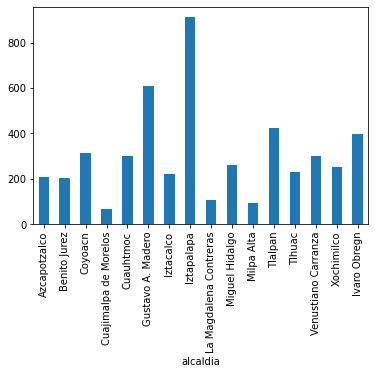

In [8]:
#Graph alcaldia variable with id

dat.groupby('alcaldia')["id"].count().plot.bar()

In [9]:
dat.groupby(['alcaldia','riesgo_precipitacion'])["id"].count()

alcaldia                riesgo_precipitacion
Azcapotzalco            Alto                     82
                        Bajo                     12
                        Medio                   112
Benito Jurez            Alto                     18
                        Bajo                    102
                        Medio                    84
Coyoacn                 Bajo                    208
                        Medio                   104
Cuajimalpa de Morelos   Alto                     30
                        Medio                    36
Cuauhtmoc               Alto                     32
                        Bajo                    175
                        Medio                    94
Gustavo A. Madero       Alto                     62
                        Bajo                    256
                        Medio                   125
                        Muy Bajo                167
Iztacalco               Bajo                    216
                   

In [10]:
geo_dict = {"type": "FeatureCollection",
            "crs": { "type": "name", 
                    "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
            "features": []
           }
dat_dict = dat.to_dict('records')

for i in range(0, len(dat_dict)):
    a = gpd.GeoSeries(dat_dict[i]['geometry']).__geo_interface__['features'][0]
    a['id'] = i
    feature =  {"type": "Feature",
                "geometry": a['geometry']}
    geo_dict['features'].append(a)
    
for i in range(0, len(dat_dict)):
    b = {'id':  dat_dict[i]['id'], 
        'Riesgo_precipitacion': dat_dict[i]['riesgo_precipitacion'],
        'riesgo_sismico': dat_dict[i]['riesgo_sismico'],
        'riesgo_granizo': dat_dict[i]['riesgo_granizo'],
        'riesgo_inundacion': dat_dict[i]['riesgo_inundacion'],
        'riesgo_laderas': dat_dict[i]['riesgo_laderas'],
        'riesgo_tormentaElectrica': dat_dict[i]['riesgo_tormentaElectrica']
        }
    geo_dict['features'][i]['properties'] = b
    
geo_dict

{'type': 'FeatureCollection',
 'crs': {'type': 'name',
  'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
 'features': [{'id': 0,
   'type': 'Feature',
   'properties': {'id': 817,
    'Riesgo_precipitacion': 'Medio',
    'riesgo_sismico': 'Medio',
    'riesgo_granizo': 'Muy Alto',
    'riesgo_inundacion': 'Muy Bajo',
    'riesgo_laderas': 'Alto',
    'riesgo_tormentaElectrica': 'Alto'},
   'geometry': {'type': 'Polygon',
    'coordinates': (((-99.2252332666058, 19.3649501948842),
      (-99.22483491184282, 19.365049511631103),
      (-99.2246166007976, 19.36450169932384),
      (-99.22452189584992, 19.364252104488553),
      (-99.22442997531118, 19.36415055525862),
      (-99.22433184262098, 19.364102008021533),
      (-99.22417244362936, 19.364084864767793),
      (-99.22397305706036, 19.364111556059942),
      (-99.22372225708624, 19.36415613360945),
      (-99.22335536524436, 19.364267361895205),
      (-99.22300470839468, 19.36446749063845),
      (-99.22273930580906, 19.

In [11]:
#Insert Dictionary of districinto Database
db.agebs.insert_one(geo_dict)

In [12]:
################################################################################
## ALCALDIAS CDMX

dat_precip['geometry'] = dat_precip.buffer(0.00001)
alcaldias = dat_precip.dissolve(by= 'alcaldia')
#alcaldias.to_file('../static/data/alcaldias.geojson', driver= 'GeoJSON')

geo_dict_alc = {"type": "FeatureCollection",
                "crs": { "type": "name", 
                        "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
                "features": []
               }
alcaldias = alcaldias.to_dict('records')

for i in range(0, len(alcaldias)):
    a = gpd.GeoSeries(alcaldias[i]['geometry']).__geo_interface__['features'][0]
    a['id'] = i
    feature =  {"type": "Feature",
                "geometry": a['geometry']}
    geo_dict_alc['features'].append(a)
    
for i in range(0, len(alcaldias)):
    b = {'id':  alcaldias[i]['id']
        }
    geo_dict_alc['features'][i]['properties'] = b
    
geo_dict_alc

/var/folders/kz/3t888q2x625230p3xfp7ysf40000gn/T/ipykernel_38345/373499685.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dat_precip['geometry'] = dat_precip.buffer(0.00001)


{'type': 'FeatureCollection',
 'crs': {'type': 'name',
  'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
 'features': [{'id': 0,
   'type': 'Feature',
   'properties': {'id': 1548},
   'geometry': {'type': 'Polygon',
    'coordinates': (((-99.17502544654543, 19.458256864471206),
      (-99.17576747616265, 19.45837707369504),
      (-99.17689321543594, 19.458559717401332),
      (-99.17745676598021, 19.45865118119557),
      (-99.17745692321047, 19.458651208002557),
      (-99.17798616023136, 19.458745789692724),
      (-99.17798651846127, 19.45874586048582),
      (-99.17878520046845, 19.45891890450323),
      (-99.17991713976012, 19.459116055118397),
      (-99.1810835078457, 19.45929144412071),
      (-99.18108385313069, 19.45929150224077),
      (-99.18201383449666, 19.45946483593347),
      (-99.18311617266049, 19.45963673250054),
      (-99.18311654691745, 19.459636798167743),
      (-99.18409984493826, 19.459828652274783),
      (-99.18419045486084, 19.459842419289068),

In [13]:
#Insert Dictionary of districinto Database
db.alcaldias.insert_one(geo_dict_alc)